In [53]:
!ls /media/inferics/DataSets/Public_Datasets/JTA-Dataset/

coco_style_convert.py  LICENSE.md	      pose.py		to_poses.py
download_data.sh       new_annotation	      __pycache__	venv
images		       new_image_annotations  README.md		videos
joint.py	       old_annotations	      requirements.txt	visualize.py
jta_banner.jpg	       old_image_annotations  to_imgs.py


In [54]:
import sys
import os

import tensorflow as tf
import numpy as np
import pathlib
import matplotlib.pyplot as plt



In [55]:
cam_intr_f = 1158
x0 = 960
y0 = 540
cam_transform = tf.constant([[cam_intr_f,0,x0],[0,cam_intr_f,y0],[0,0,1]], dtype=tf.float32)

inverse_cam_transforme = (tf.constant([[1,0,-x0],[0,1,-y0],[0,0,cam_intr_f]],dtype = tf.float32) / cam_intr_f)

inverse_cam_transforme_unscaled = tf.constant([[1,0,-x0],[0,1,-y0],[0,0,cam_intr_f]],dtype = tf.float32)

In [56]:
#TODO TEST
print(cam_transform)
print(inverse_cam_transforme)

print(tf.matmul(cam_transform, inverse_cam_transforme))

tf.Tensor(
[[1.158e+03 0.000e+00 9.600e+02]
 [0.000e+00 1.158e+03 5.400e+02]
 [0.000e+00 0.000e+00 1.000e+00]], shape=(3, 3), dtype=float32)
tf.Tensor(
[[ 8.6355786e-04  0.0000000e+00 -8.2901555e-01]
 [ 0.0000000e+00  8.6355786e-04 -4.6632123e-01]
 [ 0.0000000e+00  0.0000000e+00  1.0000000e+00]], shape=(3, 3), dtype=float32)
tf.Tensor(
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]], shape=(3, 3), dtype=float32)


In [57]:
image_path = pathlib.Path("/media/inferics/DataSets/Public_Datasets/JTA-Dataset/images")
ANNO_PATH = tf.constant("/media/inferics/DataSets/Public_Datasets/JTA-Dataset/new_image_annotations")

In [58]:
cut_dist=8
cut_delta=2
upscaling=50
original_pose_size = 80
roi_size = 20

img_downscaling = original_pose_size / roi_size

In [59]:
file_ds = tf.data.Dataset.list_files(str(image_path/'train/*/*'))

for f in file_ds.take(5):
    print(f.numpy())


b'/media/inferics/DataSets/Public_Datasets/JTA-Dataset/images/train/seq_68/282.jpg'
b'/media/inferics/DataSets/Public_Datasets/JTA-Dataset/images/train/seq_162/130.jpg'
b'/media/inferics/DataSets/Public_Datasets/JTA-Dataset/images/train/seq_144/751.jpg'
b'/media/inferics/DataSets/Public_Datasets/JTA-Dataset/images/train/seq_247/813.jpg'
b'/media/inferics/DataSets/Public_Datasets/JTA-Dataset/images/train/seq_6/374.jpg'


In [60]:


def img_path_to_annotation_path(img_path):
    # convert the path to a list of path components
    parts = tf.strings.split(img_path, os.path.sep)
    data_split = parts[-3]
    seq = parts[-2]
    img_name = parts[-1]

    anno_name = tf.strings.split(img_name, '.')[0] + '.npy'
    anno_path = tf.strings.join([ANNO_PATH,data_split,seq,anno_name], separator='/')
    # The second to last is the class-directory
    return anno_path

def pose_path_to_poses(pose_path):
    raw_poses = np.load(pose_path, allow_pickle=True)
    poses = np.empty([len(raw_poses),15,3], dtype=np.float32)
    for i, pose in enumerate(raw_poses):
        poses[i,0,0] = pose[1].x3d
        poses[i,0,1] = pose[1].y3d
        poses[i,0,2] = pose[1].z3d

        poses[i,1,0] = pose[2].x3d
        poses[i,1,1] = pose[2].y3d
        poses[i,1,2] = pose[2].z3d

        poses[i,2,0] = pose[15].x3d
        poses[i,2,1] = pose[15].y3d
        poses[i,2,2] = pose[15].z3d

        poses[i,3,0] = pose[4].x3d
        poses[i,3,1] = pose[4].y3d
        poses[i,3,2] = pose[4].z3d

        poses[i,4,0] = pose[8].x3d
        poses[i,4,1] = pose[8].y3d
        poses[i,4,2] = pose[8].z3d

        poses[i,5,0] = pose[5].x3d
        poses[i,5,1] = pose[5].y3d
        poses[i,5,2] = pose[5].z3d

        poses[i,6,0] = pose[9].x3d
        poses[i,6,1] = pose[9].y3d
        poses[i,6,2] = pose[9].z3d

        poses[i,7,0] = pose[6].x3d
        poses[i,7,1] = pose[6].y3d
        poses[i,7,2] = pose[6].z3d

        poses[i,8,0] = pose[10].x3d
        poses[i,8,1] = pose[10].y3d
        poses[i,8,2] = pose[10].z3d

        poses[i,9,0] = pose[16].x3d
        poses[i,9,1] = pose[16].y3d
        poses[i,9,2] = pose[16].z3d

        poses[i,10,0] = pose[19].x3d
        poses[i,10,1] = pose[19].y3d
        poses[i,10,2] = pose[19].z3d

        poses[i,11,0] = pose[17].x3d
        poses[i,11,1] = pose[17].y3d
        poses[i,11,2] = pose[17].z3d

        poses[i,12,0] = pose[20].x3d
        poses[i,12,1] = pose[20].y3d
        poses[i,12,2] = pose[20].z3d

        poses[i,13,0] = pose[18].x3d
        poses[i,13,1] = pose[18].y3d
        poses[i,13,2] = pose[18].z3d

        poses[i,14,0] = pose[21].x3d
        poses[i,14,1] = pose[21].y3d
        poses[i,14,2] = pose[21].z3d

    return poses

def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_png(img, channels=3)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img

def img_path_to_img_and_poses(file_path):
    anno_path = img_path_to_annotation_path(file_path)
    poses = tf.numpy_function(pose_path_to_poses, [anno_path], tf.float32)
    poses.set_shape([None,15,3])

    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, poses


In [61]:
import ShAReD_Net.data.load.dataset_jta.joint as joint
import ShAReD_Net.data.load.dataset_jta.pose as pose
sys.modules['joint'] = joint
sys.modules['pose'] = pose

In [62]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
img_poses_ds = file_ds.map(img_path_to_img_and_poses,
                         num_parallel_calls=tf.data.experimental.AUTOTUNE)


In [63]:
def img_poses_add_poss(image, poses):
    poss = poses_to_poss(poses)
    return image, poses, poss

def poses_to_poss(poses):
    poss = tf.reduce_mean(poses, axis=-2)
    return poss

In [64]:
img_poses_poss_ds = img_poses_ds.map(img_poses_add_poss)

In [65]:
def img_poses_poss_convert_img_to_imgcut(cut_dist, cut_delta, upscaling, cam_intr_f):
    def frustum_image(image, poses, poss):
        scaled_img = scale_img_to_pos(image, cut_dist, upscaling, cam_intr_f)
        filtered_poss, filtered_poses = filter_poss_and_pose(poss, poses, cut_dist, cut_delta)
        tf.print("original poss, poses",filtered_poss, filtered_poses)
        return scaled_img, filtered_poses, filtered_poss
    return frustum_image

def scale_img_to_pos(image, dist, upscaling, cam_intr_f):

    new_size = tf.cast(tf.shape(image)[:-1], dtype=tf.float32) * upscaling * dist / cam_intr_f
    sized_img = tf.image.resize_with_pad(image, tf.cast(new_size[0], dtype=tf.int32), tf.cast(new_size[1], dtype=tf.int32), antialias=True)

    return sized_img

def filter_poss_and_pose(poss, poses, dist, dist_delta):
    indexes = tf.where(tf.abs(poss[:,-1]-dist) < dist_delta)
    filtered_poss = tf.gather_nd(poss, indexes)
    filtered_poses = tf.gather_nd(poses, indexes)

    return filtered_poss, filtered_poses

In [66]:

imgcut_poses_poss_ds = img_poses_poss_ds.map(img_poses_poss_convert_img_to_imgcut(cut_dist, cut_delta, upscaling, cam_intr_f))


In [67]:
#@tf.function
def imgcut_poses_poss_convert_poses_poss_to_imgposes_imgposs(cam_transform):
    def to_img(img, poses, poss):
        poss_img = poss_to_img(poss, cam_transform)
        poses_img = poses_to_img(poses, cam_transform)
        tf.print("image poss, poses",poss_img, poses_img)
        return img, poses_img, poss_img
    return to_img

def poss_to_img(poss, cam_transform):
    poss_homog = tf.linalg.matvec(cam_transform, poss)
    poss_img = poss_homog / poss_homog[:,None,-1]
    return tf.concat([poss_img[:,:-1],poss[:,None,-1]], axis=-1)

def poses_to_img(poses, cam_transform):
    poses_homog = tf.linalg.matvec(cam_transform, poses)
    poses_img = poses_homog / poses_homog[:,:,None,-1]
    return tf.concat([poses_img[:,:,:-1],poses[:,:,None,-1]], axis=-1)


In [68]:
imgcut_imgposes_imgposs_ds = imgcut_poses_poss_ds.map(imgcut_poses_poss_convert_poses_poss_to_imgposes_imgposs(cam_transform))

In [69]:

def imgcut_imgposes_imgposs_convert_poses_poss_to_cutposes_cutposs(cut_dist, upscaling, cam_intr_f):
    def to_cut(img, poses, poss):
        poss_cut = poss_to_cut(poss, cut_dist, upscaling, cam_intr_f)
        poses_cut = poses_to_cut(poses, cut_dist, upscaling, cam_intr_f)
        poss_cut_filtered, poses_cut_filtered = filter_poss_and_pose_img_size(poss_cut, poses_cut, tf.shape(img)[:-1])
        tf.print("cut poss, poses",poss_cut_filtered, poses_cut_filtered)
        return img, poses_cut_filtered, poss_cut_filtered
    return to_cut

def poss_to_cut(poss, dist, upscaling, cam_intr_f):
    poss_cut = poss * upscaling * dist / cam_intr_f
    return tf.concat([poss_cut[:,:-1],poss[:,None,-1]], axis=-1)

def poses_to_cut(poses, dist, upscaling, cam_intr_f):
    poses_cut = poses * upscaling * dist / cam_intr_f
    return tf.concat([poses_cut[:,:,:-1],poses[:,:,None,-1]], axis=-1)

def filter_poss_and_pose_img_size(poss, poses, image_size):
    image_size = tf.cast(image_size, poss.dtype)

    indexes = tf.where(tf.math.logical_and(
        tf.math.logical_and(poss[:,0] > 0, poss[:,0] < image_size[1] - 1),
        tf.math.logical_and(poss[:,1] > 0, poss[:,1] < image_size[0] - 1)))
    filtered_poss = tf.gather_nd(poss, indexes)
    filtered_poses = tf.gather_nd(poses, indexes)

    # for each kepoint filter person not fully in image
    for k in range(15):
        indexes = tf.where(tf.math.logical_and(
            tf.math.logical_and(filtered_poses[:,k,0] > 0, filtered_poses[:,k,0] < image_size[1] - 1),
            tf.math.logical_and(filtered_poses[:,k,1] > 0, filtered_poses[:,k,1] < image_size[0] - 1)))
        
        filtered_poss = tf.gather_nd(filtered_poss, indexes)
        filtered_poses = tf.gather_nd(filtered_poses, indexes)

    return filtered_poss, filtered_poses


In [70]:
imgcut_cutposes_cutposs_ds = imgcut_imgposes_imgposs_ds.map(imgcut_imgposes_imgposs_convert_poses_poss_to_cutposes_cutposs(cut_dist, upscaling, cam_intr_f))


original poss, poses [[1.13933325 -0.312666684 7.10266685]
 [0.396 -0.286666691 6.97466612]] [[[1.14 -0.89 6.85]
  [1.13 -0.77 6.9]
  [1.16 -0.34 7.11]
  ...
  [1.23 0.15 7.04]
  [1.09 0.26 7.76]
  [1.18 0.52 7.18]]

 [[0.4 -0.86 6.71]
  [0.39 -0.76 6.76]
  [0.4 -0.32 6.96]
  ...
  [0.46 0.17 6.99]
  [0.31 0.14 7.62]
  [0.41 0.53 7.15]]]
image poss, poses [[1145.75391 489.023651 7.10266685]
 [1025.74768 492.404907 6.97466612]] [[[1152.71826 389.544525 6.85]
  [1149.64343 410.773926 6.9]
  [1148.92822 484.624481 7.11]
  ...
  [1162.32104 564.673279 7.04]
  [1122.65723 578.79895 7.76]
  [1150.31201 623.866272 7.18]]

 [[1029.03137 391.582703 6.71]
  [1026.80774 409.810638 6.76]
  [1026.55176 486.758606 6.96]
  ...
  [1036.20605 568.163086 6.99]
  [1007.11023 561.275574 7.62]
  [1026.40271 625.837769 7.15]]]
cut poss, poses [[395.769928 168.920074 7.10266685]
 [354.317 170.088058 6.97466612]] [[[398.175568 134.557693 6.85]
  [397.113464 141.890808 6.9]
  [396.866394 167.400513 7.11]
  ...

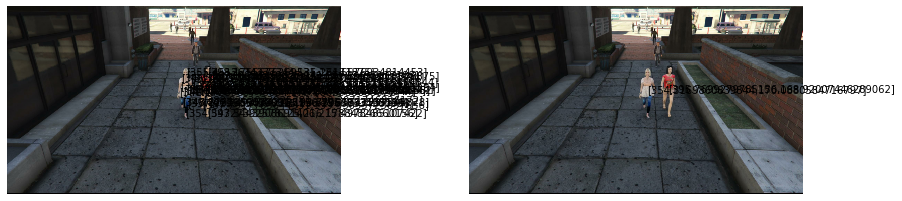

In [71]:
#TODO TEST CODE
#TEST
imgcut_cutposes_cutposs_ds_take = imgcut_cutposes_cutposs_ds.take(1)
img, poses_img, poss_img = tf.data.experimental.get_single_element(imgcut_cutposes_cutposs_ds_take)

def show_img_cut(image, poss, poses):
    print(tf.shape(image),tf.shape(poss),tf.shape(poses))

    plt.figure(figsize=(40,20))

    ax = plt.subplot(5,5,1)
    plt.imshow(image)
    for pose in poses:
        for joint in pose:
            text = f"[{joint[0]},{joint[1]}]"
            print(text)
            plt.text(joint[0],joint[1], text)
    plt.axis('off')

    ax = plt.subplot(5,5,2)
    plt.imshow(image)
    for pos in poss:
        text = f"[{pos[0]},{pos[1]}]"
        print(text)
        plt.text(pos[0],pos[1], text)
    plt.axis('off')

show_img_cut(img, poss_img, poses_img)

In [72]:
#ONLY one channel with propability
def imgcut_cutposes_cutposs_add_heatmap(cut_dist, cut_delta):
    def pos_heatmap(img, poses, poss):
        indices = tf.cast(poss[:,:-1] + 0.5, dtype = tf.int64)[:,::-1]
        dist = poss[:,-1]
        values = 1 - tf.abs(dist - cut_dist) / cut_delta 
        img_shape = tf.shape(img)

        sparse_hm = tf.SparseTensor(indices, values**2, [img_shape[0],img_shape[1]])
        heatmap = tf.expand_dims(tf.sparse.to_dense(sparse_hm, validate_indices=False),axis=-1)
        return img, poses, poss, heatmap
    return pos_heatmap




In [73]:
# VERSION with TWO channels with probapility per direction
def imgcut_cutposes_cutposs_add_heatmap(cut_dist, cut_delta):
    def pos_heatmap(img, poses, poss):
        map_indices = tf.cast(poss[:,:-1] + 0.5, dtype = tf.int64)[:,::-1]
        dist = poss[:,-1]
        values = 1 - (dist - cut_dist) / cut_delta 
        
        pos_indices = tf.where(values >= 0)
        neg_indices = tf.where(values < 0)
        pos_val = tf.gather_nd(values, pos_indices)
        neg_val = tf.abs(tf.gather_nd(values, neg_indices))
        pos_map_indices = tf.gather_nd(map_indices, pos_indices)
        neg_map_indices = tf.gather_nd(map_indices, neg_indices)

        img_shape = tf.shape(img)
        pos_sparse_hm = tf.SparseTensor(pos_map_indices, pos_val, [img_shape[0],img_shape[1]])
        pos_heatmap = tf.expand_dims(tf.sparse.to_dense(pos_sparse_hm, validate_indices=False),axis=-1)
        neg_sparse_hm = tf.SparseTensor(neg_map_indices, neg_val, [img_shape[0],img_shape[1]])
        neg_heatmap = tf.expand_dims(tf.sparse.to_dense(neg_sparse_hm, validate_indices=False),axis=-1)

        heatmap = tf.concat([neg_heatmap,pos_heatmap],axis=-1)
        return img, poses, poss, heatmap
    return pos_heatmap

In [74]:
imgcut_cutposes_cutposs_hm_ds = imgcut_cutposes_cutposs_ds.map(imgcut_cutposes_cutposs_add_heatmap(cut_dist, cut_delta))


original poss, poses [[-2.48866677 1.40799987 7.38866663]] [[[-2.46 0.88 7.01]
  [-2.49 0.94 7.11]
  [-2.49 1.4 7.4]
  ...
  [-2.45 1.76 7.73]
  [-2.56 2.14 7.74]
  [-2.53 2.07 8]]]
image poss, poses [[569.959961 760.670898 7.38866663]] [[[553.626282 685.369446 7.01]
  [554.455688 693.097046 7.11]
  [570.348633 759.081116 7.4]
  ...
  [592.975403 803.658508 7.73]
  [576.992249 860.170593 7.74]
  [593.782471 839.632446 8]]]
cut poss, poses [[196.877365 262.753357 7.38866663]] [[[191.235336 236.742477 7.01]
  [191.521835 239.411758 7.11]
  [197.011612 262.204163 7.4]
  ...
  [204.827423 277.602264 7.73]
  [199.306488 297.122833 7.74]
  [205.106201 290.028473 8]]]
tf.Tensor([373 663   3], shape=(3,), dtype=int32) tf.Tensor([1 3], shape=(2,), dtype=int32) tf.Tensor([ 1 15  3], shape=(3,), dtype=int32)
original poss, poses [[-0.440000027 -0.594 6.02266645]] [[[-0.44 -1.2 5.85]
  [-0.44 -1.08 5.89]
  [-0.42 -0.62 6.01]
  ...
  [-0.51 -0.14 5.91]
  [-0.29 0.04 6.52]
  [-0.51 0.22 6.07]]]
imag

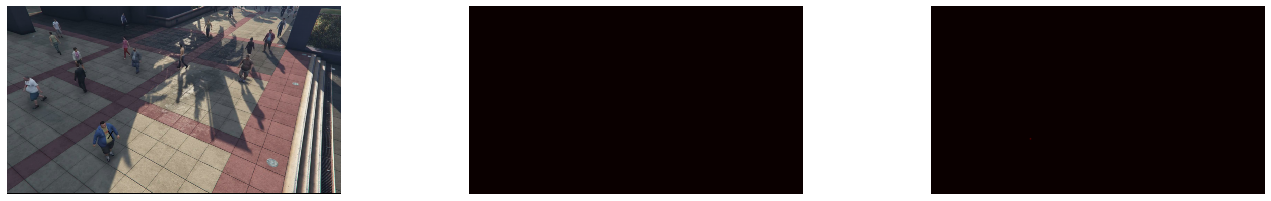

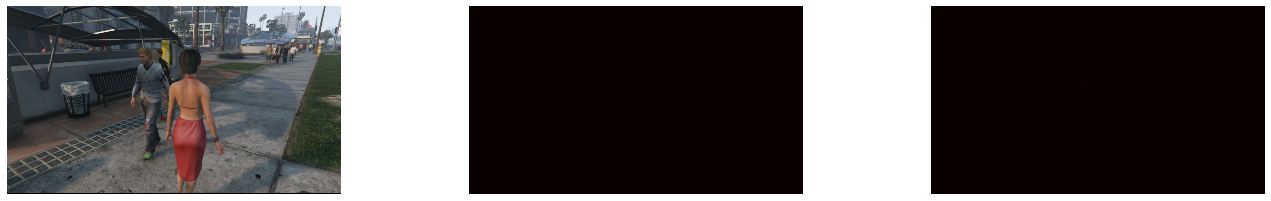

In [75]:
#TODO TEST CODE
#TEST

def show_img_and_hm(image, heatmap):
    print(tf.shape(image),tf.shape(poss),tf.shape(poses))

    plt.figure(figsize=(40,20))

    ax = plt.subplot(5,5,1)
    plt.imshow(image)
    for pos in poss:
        plt.text(pos[0],pos[1], "X")
    plt.axis('off')

    ax = plt.subplot(5,5,2)
    plt.imshow(heatmap[:,:,0], cmap="hot", interpolation="bicubic")
    plt.axis('off')

    ax = plt.subplot(5,5,3)
    plt.imshow(heatmap[:,:,1], cmap="hot", interpolation="bicubic")
    plt.axis('off')

for i in range(2):
    imgcut_cutposes_cutposs_hm_ds_take = imgcut_cutposes_cutposs_hm_ds.take(1)
    img, poses, poss, heatmap = tf.data.experimental.get_single_element(imgcut_cutposes_cutposs_hm_ds_take)
    show_img_and_hm(img, heatmap)

In [76]:
def imgcut_cutposes_cutposs_heatmap_add_weights(img, poses, poss, heatmap):
    weights = heatmap_to_weights(heatmap)
    return img, poses, poss, heatmap, weights

def heatmap_to_weights(heatmap):
    
    bin_heatmap = tf.math.ceil(heatmap)

    heatmap_batch = tf.expand_dims(bin_heatmap,axis=0)
    heatmap_3d = tf.expand_dims(heatmap_batch,axis=-1)
    
    heatmap_3d_cast = tf.cast(heatmap_3d, dtype=tf.float32) #FIX Tf Maxpool does not support Float64
    dilated_heatmap_3d_cast = tf.nn.max_pool3d(heatmap_3d_cast, ksize=3, strides=1, padding="SAME", name='dilation')
    dilated_heatmap_3d = tf.cast(dilated_heatmap_3d_cast, dtype=heatmap.dtype)
    
    dilated_heatmap = dilated_heatmap_3d[0,...,0]

    heatmap_shape = tf.shape(heatmap)
    
    nr_persons = tf.reduce_sum(bin_heatmap)
    nr_non_zeros = tf.reduce_sum(dilated_heatmap)
    nr_positions = tf.cast(tf.reduce_prod(heatmap_shape),dtype=heatmap.dtype)
    scale_negative = nr_non_zeros / nr_positions
    scale_positive = 1 - nr_persons / nr_positions
    scale_negative = tf.reshape(scale_negative,[1,1,1])
    scale_positive = tf.reshape(scale_positive,[1,1,1])

    ones = tf.ones(heatmap_shape, dtype=heatmap.dtype)
    negative_weights = (ones - dilated_heatmap) * scale_negative
    positive_weights = bin_heatmap * scale_positive
    weights = negative_weights + positive_weights
    return weights


In [77]:
imgcut_cutposes_cutposs_hm_weights_ds = imgcut_cutposes_cutposs_hm_ds.map(imgcut_cutposes_cutposs_heatmap_add_weights)


original poss, poses [[0.109999992 -3.02600026 8.63999939]
 [-1.60000014 -1.94333327 6.20466661]
 [-0.653333306 -3.14133334 8.81199932]
 [1.03733325 -3.5206666 9.60133362]
 [1.646 -3.41466641 9.41400051]] [[[0.12 -3.65 8.46]
  [0.13 -3.53 8.48]
  [0.12 -3.06 8.6]
  ...
  [0.16 -2.58 8.71]
  [0.06 -2.47 9.11]
  [0.12 -2.24 8.9]]

 [[-1.61 -2.58 5.98]
  [-1.61 -2.48 6.04]
  [-1.61 -1.95 6.19]
  ...
  [-1.43 -1.48 6.22]
  [-1.69 -1.12 6.49]
  [-1.5 -1.38 6.62]]

 [[-0.69 -3.74 8.53]
  [-0.68 -3.66 8.61]
  [-0.64 -3.18 8.87]
  ...
  [-0.57 -2.7 8.82]
  [-0.61 -2.45 9.35]
  [-0.55 -2.37 9.07]]

 [[1.04 -4.06 9.36]
  [1.02 -3.94 9.38]
  [1.03 -3.48 9.53]
  ...
  [0.96 -2.99 9.64]
  [1.16 -2.78 10.06]
  [0.99 -2.6 9.7]]

 [[1.68 -4.04 9.19]
  [1.66 -3.93 9.2]
  [1.64 -3.41 9.36]
  ...
  [1.57 -3.08 9.72]
  [1.6 -2.53 9.44]
  [1.57 -2.69 9.88]]]
image poss, poses [[974.743042 134.43187 8.63999939]
 [661.386 177.308502 6.20466661]
 [874.144348 127.191956 8.81199932]
 [1085.11084 115.378586 9.60

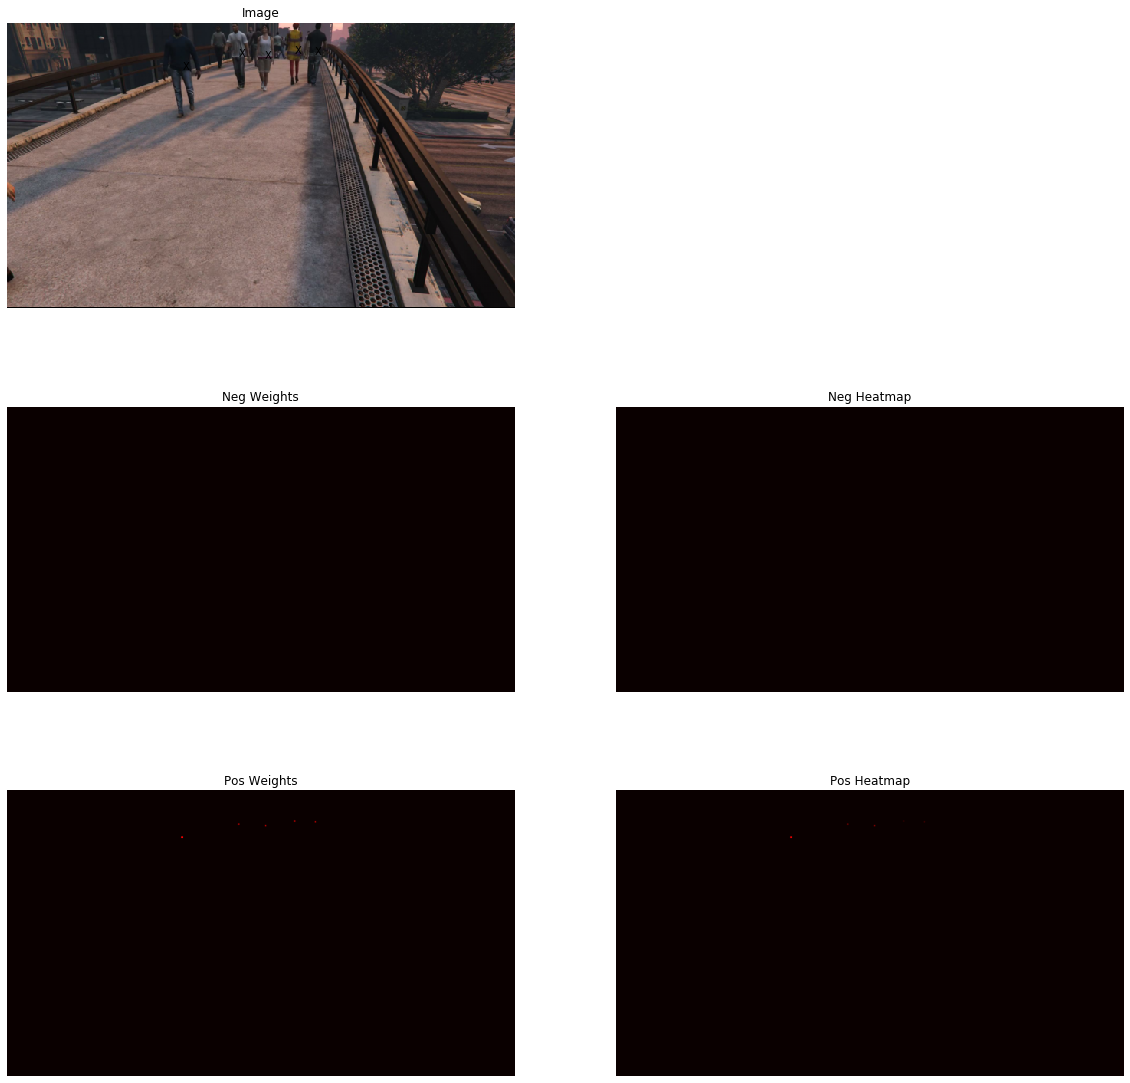

In [78]:
#TODO TEST CODE
#TEST

def show_img_and_hm_w(image, heatmap, weights):
    print(tf.shape(image),tf.shape(poss),tf.shape(poses))

    plt.figure(figsize=(20,20))

    ax = plt.subplot(3,2,1)
    plt.imshow(image)
    for pos in poss:
        plt.text(pos[0],pos[1], "X")
    plt.title('Image')
    plt.axis('off')

    ax = plt.subplot(3,2,3)
    plt.imshow(weights[:,:,0], cmap="hot", interpolation="bicubic", clim=(0.0, 1.0))
    plt.title('Neg Weights')
    plt.axis('off')

    ax = plt.subplot(3,2,4)
    plt.title('Neg Heatmap')
    plt.imshow(heatmap[:,:,0], cmap="hot", interpolation="bicubic", clim=(0.0, 1.0))
    plt.axis('off')

    ax = plt.subplot(3,2,5)
    plt.title('Pos Weights')
    plt.imshow(weights[:,:,1], cmap="hot", interpolation="bicubic", clim=(0.0, 1.0))
    plt.axis('off')

    ax = plt.subplot(3,2,6)
    plt.title('Pos Heatmap')
    plt.imshow(heatmap[:,:,1], cmap="hot", interpolation="bicubic", clim=(0.0, 1.0))
    plt.axis('off')

imgcut_cutposes_cutposs_hm_weights_ds_take = imgcut_cutposes_cutposs_hm_weights_ds.take(1)
img, poses, poss, heatmap, weights = tf.data.experimental.get_single_element(imgcut_cutposes_cutposs_hm_weights_ds_take)
show_img_and_hm_w(img, heatmap, weights)

In [79]:
def imgcut_cutposes_cutposs_heatmap_weights_add_relposes(img, poses, poss, heatmap, weights):
    rel_poses = poses_to_relposes(poses, poss)
    return img, poses, poss, heatmap, weights, rel_poses

def poses_to_relposes(poses, poss):
    rel_poses = poses - poss[:,None,:]
    return rel_poses

In [80]:
imgcut_cutposes_cutposs_heatmap_weights_relposes_ds = imgcut_cutposes_cutposs_hm_weights_ds.map(imgcut_cutposes_cutposs_heatmap_weights_add_relposes)


In [81]:
def imgcut_cutposes_cutposs_heatmap_weights_relposes_add_roiposes(img_downscaling):
    def scale_to_roi(img, poses, poss, heatmap, weights, rel_poses):
        roi_poses = rel_poses / img_downscaling
        return img, poss, poses, heatmap, weights, rel_poses, roi_poses
    return scale_to_roi

In [82]:
imgcut_cutposes_cutposs_heatmap_weights_relposes_roiposes_ds = imgcut_cutposes_cutposs_heatmap_weights_relposes_ds.map(imgcut_cutposes_cutposs_heatmap_weights_relposes_add_roiposes(img_downscaling))


In [83]:
def roi_poss_maps(x_bins, y_bins, z_bins):
    def poss_maps():
        xy_poss_map()
        z_poss_map()

In [84]:
##INVERSE roi to relative
def roi_poses_to_rel(img_downscaling):
    def scale_to_rel(poses):
        rel_poses = poses * img_downscaling
        return rel_poses
    return scale_to_rel

In [85]:
##INVERSE relativ to abs

def relativ_poss_and_poses_abs(poss, poses):
    abs_poses = poses + poss[:,None,:]
    return abs_poses

In [86]:
##INVERSE cut to img
def cut_poss_and_poses_to_img(cut_dist, upscaling, cam_intr_f):
    def to_img(img, poses, poss):
        poss_img = cut_poss_to_img(poss, cut_dist, upscaling, cam_intr_f)
        poses_img = cut_poses_to_img(poses, cut_dist, upscaling, cam_intr_f)
        tf.print("uncut poss, poses",poss_img, poses_img)
        return img, poses_img, poss_img
    return to_img

def cut_poss_to_img(poss, dist, upscaling, cam_intr_f):
    poss_cut = poss * cam_intr_f / upscaling / dist

    return tf.concat([poss_cut[:,:-1],poss[:,None,-1]], axis=-1)

def cut_poses_to_img(poses, dist, upscaling, cam_intr_f):
    poses_cut = poses * cam_intr_f / upscaling / dist

    return tf.concat([poses_cut[:,:,:-1],poses[:,:,None,-1]], axis=-1)

In [87]:
uncut_ds = imgcut_cutposes_cutposs_ds.map(cut_poss_and_poses_to_img(cut_dist, upscaling, cam_intr_f))


In [88]:
#TODO TEST test if uncut_ds == cam_ds
take_uncut = uncut_ds.take(1)
img, poss, poses = tf.data.experimental.get_single_element(take_uncut)

# image poss, poses and uncut poss, poses should have matching entrys (some are filtered out)


original poss, poses [[-5.20400095 0.0893333405 7.586]] [[[-5.21 -0.57 7.61]
  [-5.24 -0.46 7.62]
  [-5.23 0.09 7.59]
  ...
  [-4.99 0.51 7.54]
  [-5.51 0.92 7.65]
  [-4.91 0.91 7.46]]]
image poss, poses [[165.611282 553.636719 7.586]] [[[167.203659 453.264099 7.61]
  [163.685013 470.094482 7.62]
  [162.063309 553.731262 7.59]
  ...
  [193.631302 618.326294 7.54]
  [125.937241 679.262695 7.65]
  [197.831146 681.257324 7.46]]]
cut poss, poses [[57.2059708 191.238937 7.586]] [[[57.756012 156.567917 7.61]
  [56.5405922 162.381516 7.62]
  [55.9804192 191.271591 7.59]
  ...
  [66.8847351 213.584213 7.54]
  [43.5016365 234.633041 7.65]
  [68.3354568 235.322052 7.46]]]
uncut poss, poses [[165.611282 553.636719 7.586]] [[[167.203659 453.264099 7.61]
  [163.685013 470.094482 7.62]
  [162.063309 553.731262 7.59]
  ...
  [193.631302 618.326294 7.54]
  [125.937233 679.262634 7.65]
  [197.831146 681.257324 7.46]]]


In [89]:
##INVERSE cut to img
#USE the real camtransform
def img_poss_and_poses_to_real(inverse_cam_transforme):
    def to_real(img, poses, poss):
        poss_real = poss_to_real(poss, inverse_cam_transforme)
        poses_real = poses_to_real(poses, inverse_cam_transforme)
        tf.print("real poss, poses",poss_real, poses_real)
        return img, poses_real, poss_real
    return to_real

def poss_to_real(poss, inverse_cam_transforme):
    poss_homog = poss * poss[:,None,-1]
    poss_homog = tf.concat([poss_homog[:,:-1],poss[:,None,-1]], axis=-1)
    poss_real = tf.linalg.matvec(inverse_cam_transforme, poss_homog)
    return tf.concat([poss_real[:,:-1],poss[:,None,-1]], axis=-1)

def poses_to_real(poses, inverse_cam_transforme):
    poses_homog = poses * poses[:,:,None,-1]
    poses_homog = tf.concat([poses_homog[:,:,:-1],poses[:,:,None,-1]], axis=-1)
    poses_real = tf.linalg.matvec(inverse_cam_transforme, poses_homog)
    return tf.concat([poses_real[:,:,:-1],poses[:,:,None,-1]], axis=-1)

In [90]:
real_ds1 = uncut_ds.map(img_poss_and_poses_to_real(inverse_cam_transforme))
real_ds2 = imgcut_imgposes_imgposs_ds.map(img_poss_and_poses_to_real(inverse_cam_transforme))


In [91]:
#TODO TEST test if uncut_ds == cam_ds
take_real = real_ds1.take(1)
img, poss, poses = tf.data.experimental.get_single_element(take_real)

# image poss, poses and uncut poss, poses should have matching entrys (some are filtered out)

original poss, poses [[-4.636 -0.0533333272 7.44533396]] [[[-4.64 -0.72 7.49]
  [-4.65 -0.62 7.46]
  [-4.64 -0.07 7.44]
  ...
  [-4.71 0.41 7.44]
  [-4.53 0.75 7.44]
  [-4.73 0.81 7.32]]]
image poss, poses [[238.945923 531.704834 7.44533396]] [[[242.627548 428.683563 7.49]
  [238.190338 443.758698 7.46]
  [237.806488 529.104858 7.44]
  ...
  [226.911255 603.814514 7.44]
  [254.927368 656.733887 7.44]
  [211.729553 668.139343 7.32]]]
cut poss, poses [[82.5374527 183.663162 7.44533396]] [[[83.809166 148.077225 7.49]
  [82.2764511 153.284531 7.46]
  [82.1438599 182.76506 7.44]
  ...
  [78.380394 208.571518 7.44]
  [88.0578079 226.851089 7.44]
  [73.1362839 230.790802 7.32]]]
uncut poss, poses [[238.945923 531.704834 7.44533396]] [[[242.627533 428.683563 7.49]
  [238.190338 443.758698 7.46]
  [237.806458 529.104858 7.44]
  ...
  [226.911255 603.814514 7.44]
  [254.927368 656.733887 7.44]
  [211.729553 668.139404 7.32]]]
real poss, poses [[-4.636 -0.0533337593 7.44533396]] [[[-4.64 -0.71999

In [92]:
#TODO TEST test if uncut_ds == cam_ds
take_real = real_ds2.take(1)
img, poss, poses = tf.data.experimental.get_single_element(take_real)

# image poss, poses and uncut poss, poses should have matching entrys (some are filtered out)

original poss, poses [[1.34533334 0.0559999682 7.76933336]
 [0.630666673 -0.00666668033 8.14133358]
 [5.80733395 0.113999985 8.40133286]] [[[1.39 -0.6 7.84]
  [1.37 -0.5 7.81]
  [1.34 0.04 7.71]
  ...
  [1.27 0.49 7.88]
  [1.4 0.84 7.4]
  [1.28 0.89 8.01]]

 [[0.61 -0.66 8.11]
  [0.61 -0.55 8.09]
  [0.61 0 8.11]
  ...
  [0.53 0.48 8.08]
  [0.72 0.84 8.18]
  [0.54 0.88 7.95]]

 [[5.82 -0.52 8.39]
  [5.82 -0.4 8.4]
  [5.79 0.09 8.39]
  ...
  [5.9 0.6 8.44]
  [5.76 0.92 8.2]
  [5.86 0.86 8.74]]]
image poss, poses [[1160.51868 548.34668 7.76933336]
 [1049.70422 539.051758 8.14133358]
 [1760.45544 555.713257 8.40133286]] [[[1165.30872 451.377563 7.84]
  [1163.13196 465.864258 7.81]
  [1161.26074 546.007751 7.71]
  ...
  [1146.63196 612.007629 7.88]
  [1179.08105 671.448608 7.4]
  [1145.04858 668.666626 8.01]]

 [[1047.09985 445.760803 8.11]
  [1047.31519 461.273193 8.09]
  [1047.09985 540 8.11]
  ...
  [1035.95789 608.792114 8.08]
  [1061.92664 658.914368 8.18]
  [1038.65662 668.181152 7.95

In [93]:
##INVERSE img to real
#USE the scaled camtransform to avoid quantisation error, downscale later
def img_poss_and_poses_to_real(inverse_cam_transforme_unscaled, cam_intr_f):
    def to_real(img, poses, poss):
        poss_real = poss_to_real(poss, inverse_cam_transforme_unscaled, cam_intr_f)
        poses_real = poses_to_real(poses, inverse_cam_transforme_unscaled, cam_intr_f)
        tf.print("real poss, poses",poss_real, poses_real)
        return img, poses_real, poss_real
    return to_real

def poss_to_real(poss, inverse_cam_transforme_unscaled, cam_intr_f):
    poss_homog = poss * poss[:,None,-1]
    poss_homog = tf.concat([poss_homog[:,:-1],poss[:,None,-1]], axis=-1)
    poss_real_unscaled = tf.linalg.matvec(inverse_cam_transforme_unscaled, poss_homog)
    poss_real = poss_real_unscaled / cam_intr_f
    return tf.concat([poss_real[:,:-1],poss[:,None,-1]], axis=-1)

def poses_to_real(poses, inverse_cam_transforme_unscaled, cam_intr_f):
    poses_homog = poses * poses[:,:,None,-1]
    poses_homog = tf.concat([poses_homog[:,:,:-1],poses[:,:,None,-1]], axis=-1)
    poses_real_unscaled = tf.linalg.matvec(inverse_cam_transforme_unscaled, poses_homog)
    poses_real = poses_real_unscaled / cam_intr_f
    return tf.concat([poses_real[:,:,:-1],poses[:,:,None,-1]], axis=-1)

In [94]:
real_ds1 = uncut_ds.map(img_poss_and_poses_to_real(inverse_cam_transforme_unscaled, cam_intr_f))
real_ds2 = imgcut_imgposes_imgposs_ds.map(img_poss_and_poses_to_real(inverse_cam_transforme_unscaled, cam_intr_f))


In [95]:
#TODO TEST test if uncut_ds == cam_ds
take_real = real_ds1.take(1)
img, poss, poses = tf.data.experimental.get_single_element(take_real)

# image poss, poses and uncut poss, poses should have matching entrys (some are filtered out)

original poss, poses [[7.71600056 0.228 9.41533279]
 [6.95666647 0.236666679 8.71933365]] [[[7.72 -0.45 9.43]
  [7.73 -0.34 9.43]
  [7.7 0.21 9.42]
  ...
  [7.79 0.68 9.27]
  [7.67 1.09 9.6]
  [7.87 1.09 9.28]]

 [[6.98 -0.44 8.71]
  [6.94 -0.34 8.7]
  [6.94 0.21 8.7]
  ...
  [7.02 0.68 8.86]
  [6.92 1.09 8.66]
  [6.97 1.09 8.88]]]
image poss, poses [[1908.99756 568.041931 9.41533279]
 [1883.9032 571.431274 8.71933365]] [[[1908.0127 484.740173 9.43]
  [1909.24072 498.248138 9.43]
  [1906.56055 565.815308 9.42]
  ...
  [1933.11963 624.945 9.27]
  [1885.1936 671.481262 9.6]
  [1942.05396 676.015076 9.28]]

 [[1887.99536 481.501709 8.71]
  [1883.73792 494.744812 8.7]
  [1883.73792 567.951782 8.7]
  ...
  [1877.51245 628.875854 8.86]
  [1885.3302 685.75293 8.66]
  [1868.92554 682.141907 8.88]]]
cut poss, poses [] []
uncut poss, poses [] []
real poss, poses [] []


In [96]:
#TODO TEST test if uncut_ds == cam_ds
take_real = real_ds2.take(1)
img, poss, poses = tf.data.experimental.get_single_element(take_real)

# image poss, poses and uncut poss, poses should have matching entrys (some are filtered out)

original poss, poses [[3.00933313 -0.594 8.59399891]] [[[3.01 -1.23 8.52]
  [2.99 -1.13 8.57]
  [2.99 -0.58 8.61]
  ...
  [3.18 -0.15 8.47]
  [2.78 0.22 8.92]
  [3.23 0.25 8.41]]]
image poss, poses [[1365.49316 459.961334 8.59399891]] [[[1369.10559 372.823975 8.52]
  [1364.01624 387.311523 8.57]
  [1362.1394 461.993042 8.61]
  ...
  [1394.7627 519.49231 8.47]
  [1320.90137 568.560486 8.92]
  [1404.74902 574.423279 8.41]]]
real poss, poses [[3.0093329 -0.594000041 8.59399891]] [[[3.01 -1.2299999 8.52]
  [2.99 -1.13000023 8.57]
  [2.99 -0.579999924 8.61]
  ...
  [3.18000031 -0.15000017 8.47]
  [2.78000021 0.21999979 8.92]
  [3.22999978 0.25 8.41]]]


In [97]:
###### MAYPE STILL NEEDED #######

In [98]:
def crop_fixed_size(image, pos):
    upscaling = 10
    cam_intr_f = 1158
    box_size = 500

    to_cam_space(pos)[:-1] * upscaling / tf.constant([10],dtype=tf.float32)

    image_size = tf.shape(image)[:-1]
    loc_in_img = tf.cast(pos[:-1] * upscaling / pos[-1] + 0.5 , dtype=tf.int32)+image_size
    tf.print("loc",loc_in_img)
    half_box = box_size//2
    roi = tf.stack([[loc_in_img[0]-half_box,loc_in_img[1]-half_box],[loc_in_img[0]+half_box,loc_in_img[1]+half_box]])
    
    croped_img = crop_roi(image, roi)
    return croped_img

def crop_roi(image, roi):
    slide = tf.maximum(roi,0)
    crop = image[slide[0,0]:slide[1,0],slide[0,1]:slide[1,1],:]
    rd_overlap = tf.maximum(roi[1,:] - tf.shape(image)[:-1],0)
    lu_overlap = tf.maximum(- roi[0,:],0)
    
    tf.print("image_shape",tf.shape(image))
    tf.print("roi",roi)
    tf.print("paddings",rd_overlap,lu_overlap)
    tf.print("croped",tf.shape(crop))
    crop_padded = tf.pad(crop, [[lu_overlap[0],rd_overlap[0]], [lu_overlap[1],rd_overlap[1]], [0,0]])
    tf.print("padded",tf.shape(crop_padded))
    return crop_padded

def scale_img_to_pos(image, pos, upscaling):
    cam_intr_f = 1158

    new_size = tf.cast(tf.shape(image)[:-1], dtype=tf.float32) * upscaling * pos[-1] / cam_intr_f
    sized_img = tf.image.resize_with_pad(image, tf.cast(new_size[0], dtype=tf.int32), tf.cast(new_size[1], dtype=tf.int32), antialias=True)

    return sized_img

def filter_poss_and_pose(pos, poss, poses):
    indexes = tf.where(tf.abs(pos[-1] - poss[:,-1])<0.2) #TODO filter creteria
    filtered_poss = tf.gather_nd(poss, indexes)
    filtered_poses = tf.gather_nd(poses, indexes)
    return filtered_poss, filtered_poses

def frustum_image(image, poss, poses):
    upscaling = 10
    select_inx = tf.random.uniform(shape=[], maxval=tf.shape(poss)[0], dtype=tf.int32)
    pos = poss[select_inx]
    pose = poses[select_inx]

    scaled_img = scale_img_to_pos(image, pos, upscaling)
    filtered_poss, filtered_poses = filter_poss_and_pose(pos, poss, poses)

    #tensorflow only supports same sized batches, so every image must be croped
    #but cant crop at person position, else it would be trivial
    #so do a random crop, but all poss, and poses must also be croped
    #TODO croped_img = tf.image.

    return scaled_img, filtered_poss * upscaling, filtered_poses * upscaling, pos * upscaling, pose * upscaling

In [99]:
frustum_ds = pos_pose_ds.map(frustum_image)

NameError: name 'pos_pose_ds' is not defined

In [100]:
def make_ragged_annotation(anno):
    expanded = tf.expand_dims(anno, 0)
    return tf.RaggedTensor.from_tensor(expanded)

def prepare_batching(img, poss, poses, pos, pose):
    poss = make_ragged_annotation(poss)
    poses = make_ragged_annotation(poses)
    return img, poss, poses, pos, pose

def squeeze_annotation(anno):
    squeezed_anno = tf.squeeze(anno, axis=1)
    return squeezed_anno

def squeeze_batch(img_b, poss_b, poses_b, pos_b, pose_b):
    poss_b = squeeze_annotation(poss_b)
    poses_b = squeeze_annotation(poses_b)
    return img_b, poss_b, poses_b, pos_b, pose_b

In [101]:
dataset = frustum_ds.map(prepare_batching)
dataset = dataset.batch(5)
batched_ds = dataset.map(squeeze_batch)

NameError: name 'frustum_ds' is not defined

In [102]:
img_b, poss_b, poses_b, pos_b, pose_b = tf.data.experimental.get_single_element(batched_ds.take(1))
print(img_b.shape)
print(poses_b.shape)
show_batch(img_b, poses_b)


NameError: name 'batched_ds' is not defined

In [103]:
#image_batch, label_batch = tf.data.experimental.get_single_element(batched_ds.take(1))


In [104]:

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(len(image_batch)):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        poses = label_batch[n]
        for pose in poses:
            for joint in pose:
                text = f"[{joint[0]},{joint[1]}]"
                print(text)
                cam_space_joint = to_cam_space(joint)
                plt.text(cam_space_joint[0],cam_space_joint[1], text)
        plt.axis('off')